# 1. Setup

## 1.1. Using Colab GPU for Training

Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 1.2. Installing the Hugging Face Library

Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.).


In [4]:
import transformers

In [5]:
import pandas as pd

In [7]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00


# 2. Loading the data -  Hate and Offensive Speech

## 2.1 Loading the dataset from Hugging Face
This dataset can also be found on kaggle: https://www.kaggle.com/datasets/thedevastator/hate-speech-and-offensive-language-detection/data. It contains tweets labeled as hate, offensive or neither.

This dataset uploaded to Hugging Face https://huggingface.co/datasets/SetFit/hate_speech_offensive was split into training and test data.

In [8]:
from datasets import load_dataset

train_data = load_dataset("SetFit/hate_speech_offensive", split="train").to_pandas()
test_data = load_dataset("SetFit/hate_speech_offensive", split="test").to_pandas()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [9]:
test_data

,text,label,label_text
0,I been with the same STUD for a year....That b...,1,offensive language
1,"RT @andresdavid: Saying, ""Who cares?"" comes fr...",1,offensive language
2,"RT @BrosConfessions: ""People congratulate on l...",1,offensive language
3,"Bitches be like ""New Avi &gt;&gt;"" and I'm jus...",1,offensive language
4,RT @Bam_1OO: I like good weed &amp; bad bitche...,1,offensive language
...,...,...,...
1995,"RT @TerrorFranchise: ""I'm turning over a new l...",1,offensive language
1996,RT @hodgeasia: All the bitches who called me a...,1,offensive language
1997,RT @EatThePeas: I hate myself for bein so nice...,1,offensive language
1998,niggas stay with insides over some hoe shit,1,offensive language


## 2.2 Preprocessing the data

Getting rid of usernames, unnecessary columns (just for clarity, you can skip iloc this step) and extracting values to arrays.

In [10]:
train_data['text_cleaned'] = train_data['text'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
train_data.head()

,text,label,label_text,text_cleaned
0,@EvanBecker513 @_TriggaPlease_ @MorbidMermaid ...,1,offensive language,@_TriggaPlease_ @_ShayisdaBOMB_ they can see t...
1,"""@SnakecharmsDump: http://t.co/4b427dQZCV"" oh ...",1,offensive language,""": http://t.co/4b427dQZCV"" oh yeah fuck that b..."
2,Dat bitch mouth made da honor roll,1,offensive language,Dat bitch mouth made da honor roll
3,&#8220;@Al_Teez: Fuck the cowboys. My birthday...,1,offensive language,&#8220;_Teez: Fuck the cowboys. My birthday in...
4,WashPost Describes Charlie Crist's Bizarre Obs...,2,neither,WashPost Describes Charlie Crist's Bizarre Obs...


from matplotlib import pyplot as plt
_df_0['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('label_text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('text_cleaned').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('label', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text')):
  _plot_series(series, series_name, i)
  fig.legend(title='text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('label', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('label_text')):
  _plot_series(series, series_name, i)
  fig.legend(title='label_text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('label', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text_cleaned')):
  _plot_series(series, series_name, i)
  fig.legend(title='text_cleaned', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_7['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['label_text'].value_counts()
    for x_label, grp in _df_8.groupby('text')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('text')
_ = plt.ylabel('label_text')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['text_cleaned'].value_counts()
    for x_label, grp in _df_9.groupby('label_text')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('label_text')
_ = plt.ylabel('text_cleaned')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='label', y='text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['label_text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='label', y='label_text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['text_cleaned'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='label', y='text_cleaned', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [11]:
train_data_clean = train_data.loc[:,["text_cleaned", "label"]]
train_data_clean

,text_cleaned,label
0,@_TriggaPlease_ @_ShayisdaBOMB_ they can see t...,1
1,""": http://t.co/4b427dQZCV"" oh yeah fuck that b...",1
2,Dat bitch mouth made da honor roll,1
3,&#8220;_Teez: Fuck the cowboys. My birthday in...,1
4,WashPost Describes Charlie Crist's Bizarre Obs...,2
...,...,...
22778,(looks over at oomf) RT Does pretending to hav...,1
22779,108 MIL RT : And its cause of Romo bitch ass D...,1
22780,"&#8220;: ""This was hung in the boys bathroom.....",1
22781,"Breakup Anthem &#128680;&#128680;&#128680;""We ...",1


In [12]:
# Get the lists of tweets and their labels.
tweets = train_data_clean.text_cleaned.values
labels = train_data_clean.label.values

# 3. Tokenization and data formatting

## 3.1 Importing BERT tokenizer and testing the output.

In [13]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
# Print the original sentence.
print(' Original: ', tweets[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(tweets[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

 Original:  @_TriggaPlease_ @_ShayisdaBOMB_ they can see this dumbass nigger
Tokenized:  ['@', '_', 'tri', '##gga', '##ple', '##ase', '_', '@', '_', 'shay', '##is', '##da', '##bo', '##mb', '_', 'they', 'can', 'see', 'this', 'dumb', '##ass', 'ni', '##gger']
Token IDs:  [1030, 1035, 13012, 23033, 10814, 11022, 1035, 1030, 1035, 18789, 2483, 2850, 5092, 14905, 1035, 2027, 2064, 2156, 2023, 12873, 12054, 9152, 13327]


## 3.2 Required Formatting

With BERT you need to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

### Special Tokens

**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token.

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?).

**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Also, because BERT is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector.

### Sentence Length & Attention Mask

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't.

In [15]:
max_len = 0

# For every tweet...
for tweet in tweets:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum tweet length.
    max_len = max(max_len, len(input_ids))

print('Max tweet length: ', max_len)

Max tweet length:  475


This function seems to handles:
* Splitting the sentence into tokens
* Adding the special [CLS] and [SEP] tokens
* Mapping the tokens to their IDs. of the required formatting
* Padding and truncating (as warning suggests though, you should probably explicitly set truncation=True, but this code works anyway)

Max_length 64 was choosen arbitrarily, but it seems to work ok.

In [16]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for tweet in tweets:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  @_TriggaPlease_ @_ShayisdaBOMB_ they can see this dumbass nigger
Token IDs: tensor([  101,  1030,  1035, 13012, 23033, 10814, 11022,  1035,  1030,  1035,
        18789,  2483,  2850,  5092, 14905,  1035,  2027,  2064,  2156,  2023,
        12873, 12054,  9152, 13327,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [17]:
input_ids

tensor([[  101,  1030,  1035,  ...,     0,     0,     0],
        [  101,  1000,  1024,  ...,     0,     0,     0],
        [  101, 23755,  7743,  ...,     0,     0,     0],
        ...,
        [  101,  1004,  1001,  ...,     0,     0,     0],
        [  101, 19010, 11971,  ...,  2549,  8873,   102],
        [  101, 19387,  1035,  ...,     0,     0,     0]])

The attention mask simply makes it explicit which tokens are actual words versus which are padding.

The BERT vocabulary does not use the ID 0, so if a token ID is 0, then it's padding, and otherwise it's a real token.

In [18]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

## 3.3. Training & Validation Split

Divide up our training set to use 90% for training and 10% for validation.

In [19]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

## 3.4. Converting to PyTorch Data Types

Our model expects PyTorch tensors rather than numpy.ndarrays, so convert all of our dataset variables.

In [20]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

<ipython-input-20-f687c813e113>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
<ipython-input-20-f687c813e113>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_inputs)
<ipython-input-20-f687c813e113>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
<ipython-input-20-f687c813e113>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detac

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [21]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# 4. Training the Model

## 4.1. BertForSequenceClassification

We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [22]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.

In [23]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (We chose 32 when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
- Number of epochs: 2, 3, 4  (We'll use 4).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [24]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Training loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass.
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.  



Define a helper function for calculating accuracy.

In [26]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.

In [27]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

The training loop.

In [28]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    641.    Elapsed: 0:00:14.
  Batch    80  of    641.    Elapsed: 0:00:26.
  Batch   120  of    641.    Elapsed: 0:00:38.
  Batch   160  of    641.    Elapsed: 0:00:51.
  Batch   200  of    641.    Elapsed: 0:01:04.
  Batch   240  of    641.    Elapsed: 0:01:17.
  Batch   280  of    641.    Elapsed: 0:01:30.
  Batch   320  of    641.    Elapsed: 0:01:43.
  Batch   360  of    641.    Elapsed: 0:01:56.
  Batch   400  of    641.    Elapsed: 0:02:09.
  Batch   440  of    641.    Elapsed: 0:02:22.
  Batch   480  of    641.    Elapsed: 0:02:36.
  Batch   520  of    641.    Elapsed: 0:02:49.
  Batch   560  of    641.    Elapsed: 0:03:03.
  Batch   600  of    641.    Elapsed: 0:03:16.
  Batch   640  of    641.    Elapsed: 0:03:29.

  Average training loss: 0.31
  Training epcoh took: 0:03:30

Running Validation...
  Accuracy: 0.91
  Validation took: 0:00:08

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    641.    Elap

Let's take a look at our training loss over all batches:

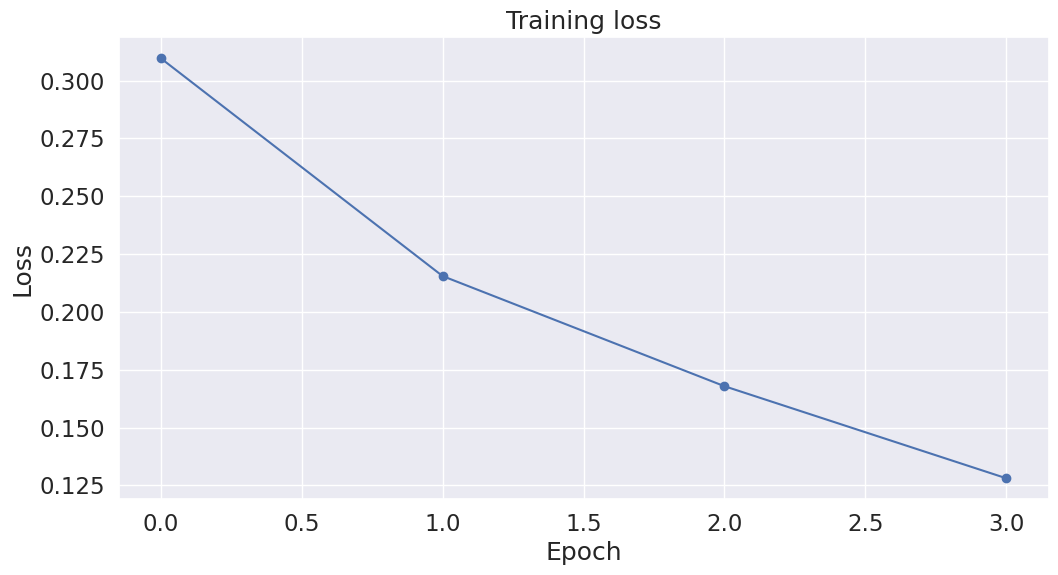

In [29]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set.

Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

We'll also calculate precision, recall, f1 score, etc.

### 5.1. Data Preparation

We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [32]:
from keras.preprocessing.sequence import pad_sequences

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_data.shape[0]))

# Create sentence and label lists
sentences = test_data.text.values
labels = test_data.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )

    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=64,
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 2,000



## 5.2. Evaluate on Test Set

With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [33]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,000 test sentences...
    DONE.


### 5.3 Classification report

In [34]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Combine the predictions from all batches
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

# Convert logits to predicted labels
predicted_labels = np.argmax(all_predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(all_true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

# Generate a classification report
report = classification_report(all_true_labels, predicted_labels, labels=[0, 1, 2])
print(f'Classification Report:\n{report}')

# Generate a confusion matrix
conf_matrix = confusion_matrix(all_true_labels, predicted_labels, labels=[0, 1, 2])
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 0.9135
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       110
           1       0.95      0.95      0.95      1532
           2       0.90      0.88      0.89       358

    accuracy                           0.91      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.91      0.91      0.91      2000

Confusion Matrix:
[[  55   50    5]
 [  44 1458   30]
 [  10   34  314]]


Accuracy: 0.9135

This indicates the overall accuracy of your model on the test set. In this case, approximately 91.35% of the instances were classified correctly.
Classification Report:

Precision: Precision is a measure of how many instances predicted as positive are actually positive.
Recall: Recall (or sensitivity) is a measure of how many actual positive instances were correctly predicted.
F1-score: F1-score is the harmonic mean of precision and recall, providing a balance between the two.
For each class (0, 1, 2):

Class 0: Precision = 0.50, Recall = 0.50, F1-score = 0.50, Support = 110
Class 1: Precision = 0.95, Recall = 0.95, F1-score = 0.95, Support = 1532
Class 2: Precision = 0.90, Recall = 0.88, F1-score = 0.89, Support = 358
Additionally:

Macro avg: Average precision, recall, and F1-score across all classes.
Weighted avg: Weighted average precision, recall, and F1-score, considering the number of instances in each class.
Confusion Matrix:

The confusion matrix provides a detailed breakdown of the model's predictions compared to the true labels.
Rows represent true classes, and columns represent predicted classes.
For example:

True class 0: Predicted as 0 (55 instances), predicted as 1 (50 instances), predicted as 2 (5 instances).
True class 1: Predicted as 0 (44 instances), predicted as 1 (1458 instances), predicted as 2 (30 instances).
True class 2: Predicted as 0 (10 instances), predicted as 1 (34 instances), predicted as 2 (314 instances).

We'll also use MCC here because the classes are imbalanced:

In [38]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.

In [39]:
matthews_set

[0.7701550637861917,
 0.8012422360248447,
 0.8288770053475936,
 0.9253038911459843,
 0.9078412990032037,
 0.6807959650786833,
 0.6713288932691089,
 0.6344761724679491,
 0.7802293021767097,
 0.9007610203946615,
 0.8012422360248447,
 0.7379860372914091,
 0.8063772025868596,
 0.5996136552992699,
 0.4686566067612416,
 0.9337758041406756,
 0.8221338222144425,
 0.7872463093467997,
 0.9211256907645913,
 1.0,
 0.9288524557385798,
 0.8232044198895028,
 0.6695340634119862,
 0.7755397388462824,
 0.5707588707889518,
 0.7966070279823608,
 0.9109156591664695,
 0.7214762303486582,
 0.5619153220690277,
 0.8509629433967631,
 0.8101514998776254,
 0.8288770053475936,
 0.5867748713296255,
 0.6250801139536578,
 0.9136445235306739,
 0.7213600767718993,
 0.8182238953695136,
 0.7802293021767097,
 0.656770203541956,
 0.7571545958898037,
 0.8511685049002077,
 0.39421492285986004,
 0.7330586805045067,
 0.6768230339923549,
 0.7598628578142771,
 0.667571849251482,
 0.8012422360248447,
 0.937185472082417,
 0.616402

In [40]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.770


The Matthews Correlation Coefficient (MCC) ranges from -1 to +1, where:

*   +1 indicates a perfect prediction,
*   0 indicates no better than random prediction,
*  -1 indicates total disagreement between prediction and observation.

0.770: This is a high MCC value, suggesting that the model has a strong positive correlation between its predictions and the true labels. This indicates good overall performance in terms of both true positives and true negatives, while considering the balance with false positives and false negatives.

# Conclusion

With a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.

## Saving & Loading Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.



In [44]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [42]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Paste your drive directory here:

In [47]:
# Copy the model files to a directory in your Google Drive (dir_to_save).
!cp -r ./model_save/ "/content/drive/dir_to_save"

Saved files:

In [48]:
!ls -l --block-size=K ./model_save/

total 427944K
-rw-r--r-- 1 root root      1K Jan 18 11:18 config.json
-rw-r--r-- 1 root root 427697K Jan 18 11:18 model.safetensors
-rw-r--r-- 1 root root      1K Jan 18 11:18 special_tokens_map.json
-rw-r--r-- 1 root root      2K Jan 18 11:18 tokenizer_config.json
-rw-r--r-- 1 root root    227K Jan 18 11:18 vocab.txt


### You can transfer the model to your Hugging Face repo and load it

In [52]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the saved model and tokenizer (this is a path to the repo with the model trained in this notebook)
model = AutoModelForSequenceClassification.from_pretrained('MartynaKopyta/BERT_hate_offensive_tweets')
tokenizer = AutoTokenizer.from_pretrained('MartynaKopyta/BERT_hate_offensive_tweets')


config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [54]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [55]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,000 test sentences...
    DONE.


In [56]:
# Combine the predictions from all batches
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

# Convert logits to predicted labels
predicted_labels = np.argmax(all_predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(all_true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

# Generate a classification report
report = classification_report(all_true_labels, predicted_labels, labels=[0, 1, 2])
print(f'Classification Report:\n{report}')

# Generate a confusion matrix
conf_matrix = confusion_matrix(all_true_labels, predicted_labels, labels=[0, 1, 2])
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.9135
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       110
           1       0.95      0.95      0.95      1532
           2       0.90      0.88      0.89       358

    accuracy                           0.91      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.91      0.91      0.91      2000

Confusion Matrix:
[[  55   50    5]
 [  44 1458   30]
 [  10   34  314]]
